# How does a neural net really work?

## Fitting a function with gradient descent

A neural network is just a mathematical function. The function:

  1. Multiplies each input by a number of values. These values are known as parameters
  2. Adds them up for each group of values
  3. Replaces the negative numbers with zeros
  
This represents one "layer". Then these three steps are repeated, using the outputs of the previous layer as the inputs to the next layer.
Initially, the parameters in this function are selected randomly. Therefore a newly created neural network doesn't do anything useful at all -- it's just random!

To get the function to "learn" to do something useful, we have to change the parameters to make them "better" in some way. We do this using *gradient descent*:

In [3]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max = 2.1, color ='b', ylim=None):
    x = torch.linspace(min, max, 100)[:, None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

We are going to fit a quadratic to learn how gradient descent works.

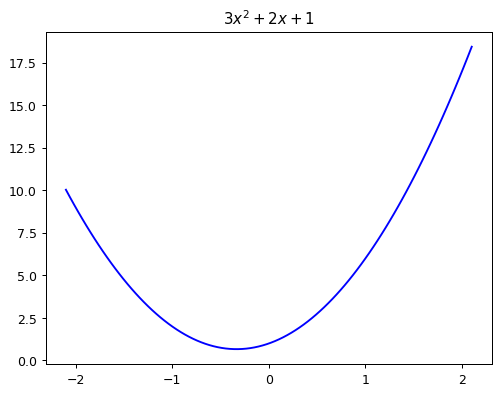

In [ ]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

Let's create a function that calculates the value of a point on any quadratic to be easier to try out different quadratics for fitting a model to the data we'll create:

In [5]:
def quad(a, b, c, x): return a*x**2 + b*x + c

If we fix some particular values of a, b, and c, then we'll have made a quadratic. To fix values passed to a function in Python, we use the partial function, like so:

In [6]:
def mk_quad(a, b, c): return partial(quad, a, b, c)

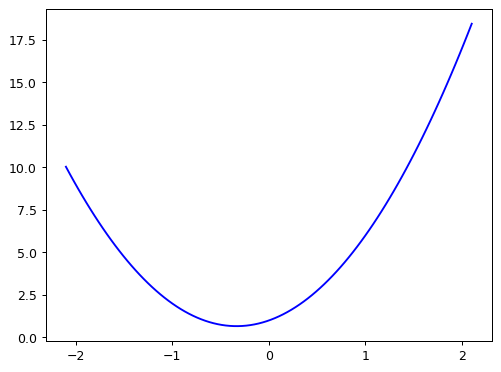

In [7]:
f2 = mk_quad(3, 2, 1)
plot_function(f2)

In practice, the line will never fit perfectly because of the noise.
So, let's simulate making some noisy measurements ofo ur quadratic f2.
Then, we will use gradient descent to see if we can recreate the original function from the data!

Add random noise to data:

In [9]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1 + noise(x, mult)) + noise(x, add)

np.random.normal(m,s,n) - used to model probabilistic experiments with the help of normal distribution.

m: the mean of the normal distribution.

s: the standard deviation of the distribution.

n: the total number of samples to be drawn.



In [10]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:, None]
y = add_noise(f(x), 0.15, 1.5)

In [11]:
x[:5], y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

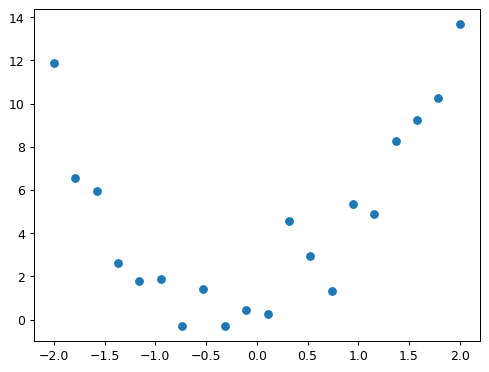

In [12]:
plt.scatter(x, y);

Now it's time to find values of a, b, and c which fit this data. One approach is to try a few values and see what fits:

In [14]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x, y)
    plot_function(mk_quad(a, b, c), ylim=(-3, 13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

Move the slider a little by little until it fits the dots. Try to fit the quadratic to the data. Next, do the same for slider b. Then, the same for the slider c.

Now, let's go back to slider a and repeat the whole you just did.

Did you notice that by going back and doing the sliders a second time that you were able to improve things a bit further? That's an important insight -- it's only after changing b and c, for instance, that you realise that a actually needs some adjustment based on those new values.

One thing that's making this tricky is that we don't really have a great sense of whether our fit is really better or worse. It would be easier if we had a numeric measure of that.

On easy metric we could use is mean absolute error -- which is the distance from each data point to the curve:

In [15]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

In [21]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a, b, c)
    plt.scatter(x, y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3, 12), title=f"MAE: {loss: .2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In a modern neural network we'll often have tens of millions of parameters to fit, or more, and thousands or millions of data points to fit them to. We're not going to be able to do that by moving sliders around! We'll need to automate this process.

Thankfully, that turns out to be pretty straightforward. We can use calculus (derivatives) to figure out , for each parameter, whether we should increase or decrease it.

*derivatives*: measure the rate of change of a function

## Automating gradient descent

The basic idea: if we know the gradient of our mae() function *with respect* to our parameters, a, b, c, then it means that we know how adjusting, for example, a will change the value of mae().

For instance, a has a negative gradient, then we know that increasing a will decrease mae() - think of what mae() calculates, the distance between the line and the points.

So, finding the *gradient* of mae() for each of our parameters, and then adjusting our parameters a bit in the *opposite* direction to the sign of the gradient.

To do this, we need a function that takes all the parameters a, b, and c as single vector input, and returns the value mae() based on those parameters:

In [19]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [20]:
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

Observe: that's the same as the starting mae() we had in our plot before

We're first going to do exactly the same thing as we did manually -- pick some arbritrary starting point for our parameters. We'll put them all into a single tensor:

In [22]:
abc = torch.tensor([1.1, 1.1, 1.1])

To tell PyTorch that we want it to calculate gradients for these parameters, we need to call requires_grad_():

In [23]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

We can now calculate mae(). Generally, when doing gradient descent, the thing we're trying to minimise is called the loss:

In [24]:
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

To get PyTorch to now calculate the gradients, we need to call backward():

In [25]:
loss.backward()

The gradients will be stored for us in an attribute called grad:

In [26]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

According to these gradients, all our parameters are a little low. So let's increase them a bit. If we subtract the gradient, multiplied by a small number, that should improve them a bit:

In [27]:
with torch.no_grad():
    abc-= abc.grad*0.01
    loss = quad_mae(abc)
print(f'loss={loss:.2f}')

loss=2.40


The "small number" we multiply is called the *learning rate*, and is the most important hyper-parameter to set when training a neural network.

BTW, you'll see we had to wrap our calculation of the new parameters in with torch.no_grad(). That *disables the calculation of gradients* for any operations inside that context manager. We have to do that, because abc -= abc.grad*0.01 isn't actually part of our quadratic model, so we don't want derivitives to include that calculation.

In [28]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss: .2f}')

step=0; loss= 2.40
step=1; loss= 2.36
step=2; loss= 2.30
step=3; loss= 2.21
step=4; loss= 2.11
step=5; loss= 1.98
step=6; loss= 1.85
step=7; loss= 1.72
step=8; loss= 1.58
step=9; loss= 1.46


If you keep running this loop for long enough however, you'll see that the loss eventually starts increasing for a while. That's because once the parameters get close to the correct answer, our parameter updates will jump right over the correct answer! 

To avoid this, we need to decrease our learning rate as we train. This is done using a learning rate schedule, and can be automated in most deep learning frameworks, such as fastai and PyTorch.

## How a neural network approximates any given function

A neural network is a very expressive function. In fact -- it's infinitely expressive.

A neural network can approximate any computable function, given enough parameters. A "computable function" can cover just about anything you can imagine: understand and translate human speech; paint a picture; diagnose a disease from medical imaging; write an essay; etc...

The way a neural network approximates a function actually turns out to be very simple. The key trick is to combine two extremely basic steps:

  1. Matrix multiplication, which is just multiplying things together and then adding them up
  2. The function max(x, 0) , which simply replaces all negative numbers with zero.
  
The combination of a linear function and this max() is called a rectified linear function, and it can be implemented like this:

In [29]:
def rectified_linear(m, b, x):
    y = m*x + b
    return torch.clip(y, 0)

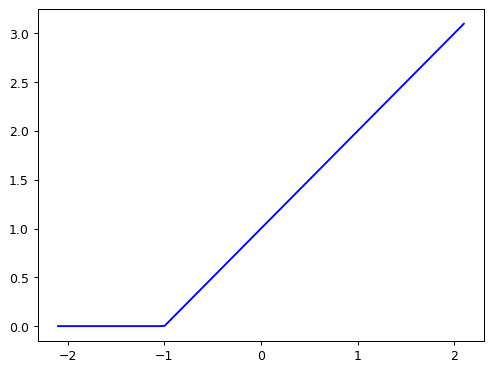

In [30]:
plot_function(partial(rectified_linear, 1, 1))

BTW, instead of torch.clip(y, 0.), we can instead use F.relu(x), which does exactly the same thing. In PyTorch, F refers to the torch.nn.functional module.

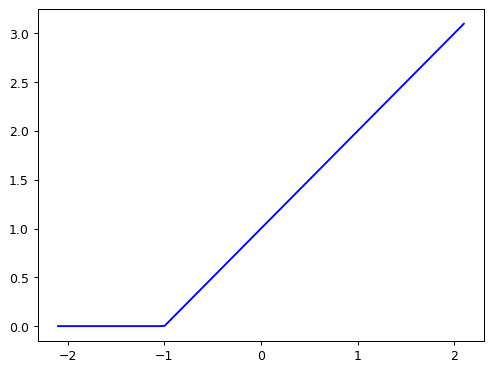

In [31]:
import torch.nn.functional as F
def rectified_linear2(m, b, x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1, 1))

In [33]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), ylim=(-1, 4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

As you see, m changes the slope, and b changes where the "hook" appears.

This function doesn't do much on its own, but look what happens when we add two of them together:

In [35]:
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

@interact(m1 = -1.5, b1 = -1.5, m2 = 1.5, b2 = 1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1, b1, m2, b2), ylim=(-1, 6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

If you play around with that for a while, you notice something quite profound: with enough of these rectified linear functions added together, you could approximate any function with a single input, to whatever accuracy you like! Any time the function doesn't quite match, you can just add a few more additions to the mix to make it a bit closer.

In [41]:
def triple_relu(m1, b1, m2, b2, m3, b3, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x) + rectified_linear(m3, b3, x)

@interact(m1 = -1.5, b1 = -1.5, m2 = 1.5, b2 = 1.5, m3 = 2, b3 = 2)
def plot_trile_relu(m1, b1, m2, b2, m3, b3):
    plt.scatter(x, y)
    loss = mae(f(x), y)
    plot_function(partial(triple_relu, m1, b1, m2, b2, m3, b3), ylim=(-1, 6), title=f"MAE: {loss: .2f}")

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

## How to recognise an owl

"OK great, we've created a nifty little example showing that we can drawing squiggly lines that go through some points. So what?

Well... the truth is that actually drawing squiggly lines (or planes, or high-dimensional hyperplanes...) through some points is literally all that deep learning does! If your data points are, say, the RGB values of pixels in photos of owls, then you can create an owl-recogniser model by following the exact steps above."

"Students often ask me at this point "OK Jeremy, but how do neural nets actually work". But at a foundational level, there is no "step 2". We're done -- the above steps will, given enough time and enough data, create (for example) an owl recogniser, if you feed in enough owls (and non-owls).

The devil, I guess, is in the "given enough time and enough data" part of the above sentence. There's a lot of tweaks we can make to reduce both of these things. For instance, instead of running our calculations on a normal CPU, as we've done above, we could do thousands of them simultaneously by taking advantage of a GPU. We could greatly reduce the amount of computation and data needed by using a convolution instead of a matrix multiplication, which basically means skipping over a bunch of the multiplications and additions for bits that you'd guess won't be important. We could make things much faster if, instead of starting with random parameters, we start with parameters of someone else's model that does something similar to what we want (this is called transfer learning)."